<a href="https://colab.research.google.com/github/drashya17/Face-Detection/blob/main/face_deteciton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project Part 1
###PROJECT OBJECTIVE: Face detection from training images.


###Import Liberaries

In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [ ]:
import warnings
warnings.filterwarnings('ignore')
print("Warnings ignored!!")

Warnings ignored!!


###Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir("/content/drive/MyDrive/computer vision/")

### 1. Import the dataset.

In [ ]:
data = np.load("Part 1- Train data - images.npy", allow_pickle = True)

Check the shape

In [ ]:
data.shape

(409, 2)

### Check one sample

In [ ]:
a = data[1,0]

In [ ]:
a.shape

(697, 1280, 4)

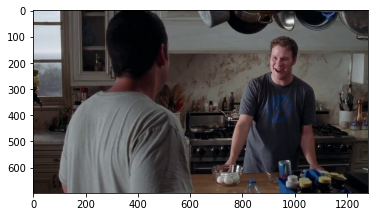

In [ ]:
plt.imshow(a)
plt.show()

In [ ]:
data[408,1]

[{'imageHeight': 493,
  'imageWidth': 656,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.3201219512195122, 'y': 0.2839756592292089},
   {'x': 0.4009146341463415, 'y': 0.4198782961460446}]},
 {'imageHeight': 493,
  'imageWidth': 656,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.4557926829268293, 'y': 0.38742393509127787},
   {'x': 0.5442073170731707, 'y': 0.5618661257606491}]},
 {'imageHeight': 493,
  'imageWidth': 656,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.6707317073170732, 'y': 0.38336713995943206},
   {'x': 0.7134146341463414, 'y': 0.4746450304259635}]},
 {'imageHeight': 493,
  'imageWidth': 656,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.16615853658536586, 'y': 0.4665314401622718},
   {'x': 0.22560975609756098, 'y': 0.563894523326572}]},
 {'imageHeight': 493,
  'imageWidth': 656,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.07164634146341463, 'y': 0.539553752535497},
   {'x': 0.11280487804878049, 'y': 0.586206896551

### Set Image Dimensions

In [ ]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

### 2. Create features (images) and labels (mask) using that data.
* Here feature is the image
* The label is the mask
* Images will be stored in "X_train" array
* Masks will be stored in "masks" array

In [ ]:
masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [ ]:
print('Shape of X_train: ', X_train.shape)
print('Shape of mask array: ', masks.shape)

Shape of X_train:  (409, 224, 224, 3)
Shape of mask array:  (409, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 ...

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]

 [[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]]]


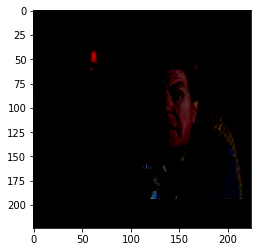

In [ ]:
from matplotlib import pyplot
n = 20
print(X_train[n])
pyplot.imshow(X_train[n])

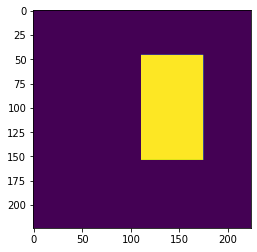

In [ ]:
pyplot.imshow(masks[n])

### 3. Mask detection model
● Design a face mask detection model. 
 Hint: Use U-net along with pre-trained transfer learning models

In [ ]:
HEIGHT_CELLS = 28
WIDTH_CELLS = 28

CELL_WIDTH = IMAGE_WIDTH / WIDTH_CELLS
CELL_HEIGHT = IMAGE_HEIGHT / HEIGHT_CELLS

In [ ]:
def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights='imagenet')
    for layer in model.layers:
        layer.trainable = trainable

    block0 = model.get_layer("conv_pw_1_relu").output 
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block0])
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)

    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)

    return Model(inputs=model.input, outputs=x)

In [ ]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model()

# Print summary
model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
_____________________________

### ● Design your own Dice Coefficient and Loss function. 

In [ ]:
def dice_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

In [ ]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### ● Train, tune and test the model

In [ ]:
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

###Define Checkpoint and early stopping

In [ ]:
PATIENCE = 5

In [ ]:
#checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True, save_weights_only=True, mode="min", period=1)
checkpoint = ModelCheckpoint("/content/drive/MyDrive/computer vision/modelsaved.h5", monitor="loss", verbose=1, save_best_only=True, save_weights_only=True, mode="auto", save_freq=1)
stop = EarlyStopping(monitor="loss", patience=PATIENCE, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=PATIENCE, min_lr=1e-6, verbose=1, mode="min")

###● Evaluate the model using testing data

In [ ]:
EPOCHS = 10
BATCH_SIZE = 1
THREADS = 5

In [ ]:
model.fit(x=X_train, y=masks, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, callbacks=[checkpoint,reduce_lr, stop], validation_split=0.2, workers=THREADS, use_multiprocessing=True)

Streaming output truncated to the last 5000 lines.
Epoch 00003: loss did not improve from 0.45300
125/327 [==========>...................] - ETA: 12s - loss: 0.5988 - dice_coefficient: 0.6799
Epoch 00003: loss did not improve from 0.45300
126/327 [==========>...................] - ETA: 12s - loss: 0.5987 - dice_coefficient: 0.6797
Epoch 00003: loss did not improve from 0.45300
127/327 [==========>...................] - ETA: 12s - loss: 0.5980 - dice_coefficient: 0.6802
Epoch 00003: loss did not improve from 0.45300
128/327 [==========>...................] - ETA: 12s - loss: 0.6004 - dice_coefficient: 0.6781
Epoch 00003: loss did not improve from 0.45300
129/327 [==========>...................] - ETA: 12s - loss: 0.6019 - dice_coefficient: 0.6768
Epoch 00003: loss did not improve from 0.45300
130/327 [==========>...................] - ETA: 11s - loss: 0.6044 - dice_coefficient: 0.6747
Epoch 00003: loss did not improve from 0.45300
131/327 [===========>..................] - ETA: 11s - lo

Get the predicted mask for a sample image

In [ ]:
model.load_weights("/content/drive/MyDrive/computer vision/modelsaved.h5")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


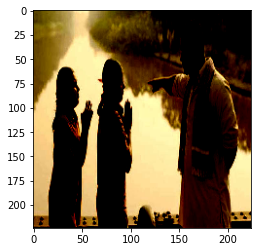

In [ ]:
n = 29
sample_image = X_train[n]
final_image = sample_image
pyplot.imshow(sample_image)

In [ ]:
sample_image.shape

(224, 224, 3)

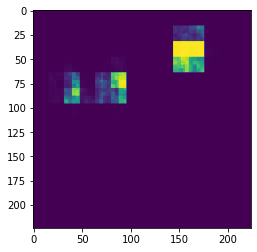

In [ ]:
sample_image = np.resize(sample_image, (1, 224, 224, 3))
pred_mask = model.predict(x=sample_image)
pred_mask = np.resize(pred_mask, (224, 224))
pyplot.imshow(pred_mask)

###Impose the mask on the image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


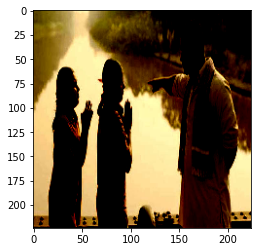

In [ ]:
final_pred_mask = np.resize(pred_mask, (224,224))
final_image = np.resize(sample_image,  (224,224,3))
pyplot.imshow(final_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


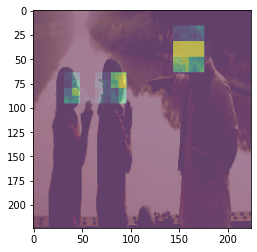

In [ ]:
fig = plt.figure()
im1 = plt.imshow(final_image, alpha=0.5)
im2 = plt.imshow(final_pred_mask, alpha=0.5)
plt.show()

### 4. Use the “Prediction image” as an input to your designed model and display the output of the image

(500, 500, 3)


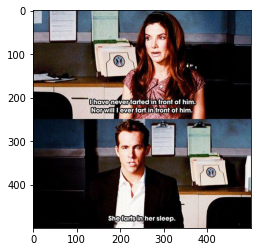

In [ ]:
import cv2 as cv
img = plt.imread('/content/drive/MyDrive/computer vision/Part 1Test Data - Prediction Image.jpeg')
plt.imshow(img)
print(img.shape)

**To mask above image we have to create bounding box first around our image.**

In [ ]:
def box_corner_to_center(boxes):
    """Convert from (upper-left, lower-right) to (center, width, height)."""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = tf.stack((cx, cy, w, h), axis=-1)
    return boxes


def box_center_to_corner(boxes):
    """Convert from (center, width, height) to (upper-left, lower-right)."""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = tf.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [ ]:
# Here `bbox` is the abbreviation for bounding box
face1_bbox, face2_bbox = [230.0, 20.0, 340.0, 130.0], [180.0, 250.0, 280.0, 390.0]

In [ ]:
boxes = tf.constant((face1_bbox, face2_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

<tf.Tensor: shape=(2, 4), dtype=bool, numpy=
array([[ True,  True,  True,  True],
       [ True,  True,  True,  True]])>

In [ ]:
def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    # Convert the bounding box (upper-left x, upper-left y, lower-right x,
    # lower-right y) format to the matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    return plt.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2] - bbox[0],
                             height=bbox[3] - bbox[1], fill=False,
                             edgecolor=color, linewidth=2)

(500, 500, 3)


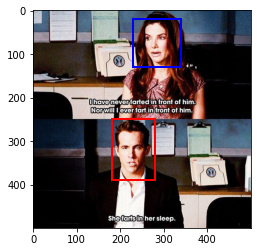

In [ ]:
fig = plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(face1_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(face2_bbox, 'red'))
print(img.shape)

**Predicted Mask**

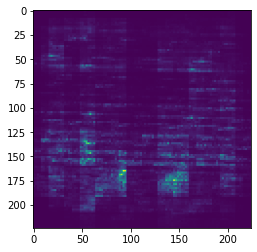

In [ ]:
img = np.resize(img, (1,224,224, 3))
pred_mask1 = model.predict(x = img)
pred_mask1 = np.resize(pred_mask1, (224,224))
plt.imshow(pred_mask1)

**Mask imposed on image**

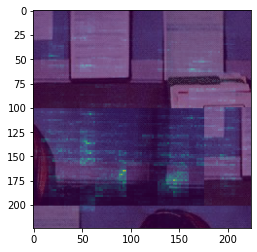

In [ ]:
final_pred_mask = np.resize(pred_mask1, (224,224))
final_image = np.resize(img, (500,500,3))
img_1 = plt.imshow(final_image)
img_2 = plt.imshow(final_pred_mask, alpha = 0.6)
plt.show()

**Conclusion**

Project was all about how we can make use of a pretrained MobileNet (Transfer Learning) and on top of it add all the UNET layers to train, fit and evaluate model with an objective to predict the boundaries(mask) around the face in a given image.

* Model was complied using binary cross entropy as loss, adam optimizer and dice coefficient as metrics.
Model checkpoint, early stopping and learning rate reducers were used as callbacks.
* Data was split into train and validation using 90/10 ratio. Best loss I got is 0.4323 and dice_coefficient of 0.7652 on the training data with just 10 epochs.
* Model weights for this were used and then used to predict on validation data to get mask.
* Further checked on sample image and imposed mask on the image.
As seen in the above images, it can be seen that model does a very good job in predicting the masks.